In [33]:
from collections import OrderedDict
import torch
import torch.nn as nn
import logging
import pickle, os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam

In [34]:
class CLSTM_cell(nn.Module):
    def __init__(self, shape, input_channels, filter_size, num_features):
        super(CLSTM_cell, self).__init__()

        self.shape = shape  # H, W
        self.input_channels = input_channels

        if type(filter_size) == tuple:  # PFC size (1, W)
            assert filter_size[0] == 1
            self.filter_size = filter_size
            self.padding = "same"
        else:
            self.filter_size = filter_size
            self.padding = (filter_size - 1) // 2

        self.num_features = num_features
        # in this way the output has the same size
        self.conv = nn.Sequential(
            nn.Conv2d(
                self.input_channels + self.num_features,
                4 * self.num_features,
                self.filter_size,
                1,
                self.padding,
            ),
            nn.GroupNorm(4 * self.num_features // 32, 4 * self.num_features),
        )

    def forward(self, inputs=None, hidden_state=None, seq_len=10):
        #  seq_len=10 for moving_mnist
        if hidden_state is None:
            hx = torch.zeros(
                inputs.size(1), self.num_features, self.shape[0], self.shape[1]
            )
            cx = torch.zeros(
                inputs.size(1), self.num_features, self.shape[0], self.shape[1]
            )
        else:
            hx, cx = hidden_state
        output_inner = []
        for index in range(seq_len):
            if inputs is None:
                x = torch.zeros(
                    hx.size(0), self.input_channels, self.shape[0], self.shape[1]
                )
            else:
                x = inputs[index, ...]

            combined = torch.cat((x, hx), 1)
            gates = self.conv(combined)  # gates: S, num_features*4, H, W
            # it should return 4 tensors: i,f,g,o
            ingate, forgetgate, cellgate, outgate = torch.split(
                gates, self.num_features, dim=1
            )
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            output_inner.append(hy)
            hx = hy
            cx = cy
        return torch.stack(output_inner), (hy, cy)


In [35]:
def make_layers(block):
    layers = []
    for layer_name, v in block.items():
        if "pool" in layer_name:
            layer = nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])
            layers.append((layer_name, layer))
        elif "deconv" in layer_name:
            transposeConv2d = nn.ConvTranspose2d(
                in_channels=v[0],
                out_channels=v[1],
                kernel_size=v[2],
                stride=v[3],
                padding=v[4],
            )
            layers.append((layer_name, transposeConv2d))
            if "relu" in layer_name:
                layers.append(("relu_" + layer_name, nn.ReLU(inplace=True)))
            elif "leaky" in layer_name:
                layers.append(
                    (
                        "leaky_" + layer_name,
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                    )
                )
        elif "conv" in layer_name:
            conv2d = nn.Conv2d(
                in_channels=v[0],
                out_channels=v[1],
                kernel_size=v[2],
                stride=v[3],
                padding=v[4],
            )
            layers.append((layer_name, conv2d))
            if "relu" in layer_name:
                layers.append(("relu_" + layer_name, nn.ReLU(inplace=True)))
            elif "leaky" in layer_name:
                layers.append(
                    (
                        "leaky_" + layer_name,
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                    )
                )
        else:
            raise NotImplementedError
    return nn.Sequential(OrderedDict(layers))


In [36]:
class Encoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)
        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns), 1):
            # index sign from 1
            setattr(self, "stage" + str(index), make_layers(params))
            setattr(self, "rnn" + str(index), rnn)

    def forward_by_stage(self, inputs, subnet, rnn):
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        inputs = subnet(inputs)
        inputs = torch.reshape(
            inputs,
            (seq_number, batch_size, inputs.size(1), inputs.size(2), inputs.size(3)),
        )
        outputs_stage, state_stage = rnn(inputs, None)
        return outputs_stage, state_stage

    def forward(self, inputs):
        inputs = inputs.transpose(0, 1)  # to S,B,1,64,64
        hidden_states = []
        logging.debug(inputs.size())
        for i in range(1, self.blocks + 1):
            inputs, state_stage = self.forward_by_stage(
                inputs, getattr(self, "stage" + str(i)), getattr(self, "rnn" + str(i))
            )
            hidden_states.append(state_stage)
        return tuple(hidden_states)



In [37]:
class Decoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)

        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns)):
            setattr(self, "rnn" + str(self.blocks - index), rnn)
            setattr(self, "stage" + str(self.blocks - index), make_layers(params))

    def forward_by_stage(self, inputs, state, subnet, rnn):
        inputs, state_stage = rnn(inputs, state, seq_len=10)
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        inputs = subnet(inputs)
        inputs = torch.reshape(
            inputs,
            (seq_number, batch_size, inputs.size(1), inputs.size(2), inputs.size(3)),
        )
        return inputs

        # input: 5D S*B*C*H*W

    def forward(self, hidden_states):
        inputs = self.forward_by_stage(
            None, hidden_states[-1], getattr(self, "stage3"), getattr(self, "rnn3")
        )
        for i in list(range(1, self.blocks))[::-1]:
            inputs = self.forward_by_stage(
                inputs,
                hidden_states[i - 1],
                getattr(self, "stage" + str(i)),
                getattr(self, "rnn" + str(i)),
            )
        inputs = inputs.transpose(0, 1)  # to B,S,1,64,64
        return inputs


# Experiment


In [38]:
# convlstm_encoder_params = [
#     [
#         OrderedDict(
#             {"conv1_leaky_1": [1, 16, 3, 1, 1]}
#         ),  # in_channel, out_channel, kernel_size, stride, padding
#         OrderedDict({"conv2_leaky_1": [64, 64, 3, 2, 1]}),
#         OrderedDict({"conv3_leaky_1": [96, 96, 3, 2, 1]}),
#     ],
#     [
#         CLSTM_cell(shape=(64, 64), input_channels=16, filter_size=5, num_features=64),
#         CLSTM_cell(shape=(32, 32), input_channels=64, filter_size=5, num_features=96),
#         CLSTM_cell(shape=(16, 16), input_channels=96, filter_size=5, num_features=96),
#     ],
# ]
# convlstm_decoder_params = [
#     [
#         OrderedDict({"deconv1_leaky_1": [96, 96, 4, 2, 1]}),
#         OrderedDict({"deconv2_leaky_1": [96, 96, 4, 2, 1]}),
#         OrderedDict(
#             {"conv3_leaky_1": [64, 16, 3, 1, 1], "conv4_leaky_1": [16, 1, 1, 1, 0]}
#         ),
#     ],
#     [
#         CLSTM_cell(shape=(16, 16), input_channels=96, filter_size=5, num_features=96),
#         CLSTM_cell(shape=(32, 32), input_channels=96, filter_size=5, num_features=96),
#         CLSTM_cell(shape=(64, 64), input_channels=96, filter_size=5, num_features=64),
#     ],
# ]


### Experimenting with `CLSTM_cell`


In [39]:
# conv = CLSTM_cell((32, 32), 3, 5, 24)
# print(conv)

# batch_size = 11
# in_channels = 3
# frame_size = (32, 32)
# seq_length = 12
# X = torch.rand(batch_size, seq_length, in_channels, *frame_size)

# # Need switch the batch_size and seq_length dimensions
# outputs, (h, c) = conv(X.transpose(0, 1))

# print(outputs.size())
# print(h.size())
# print(c.size())

# # Outputs are the collection of cell states in the sequence
# print((outputs[-1] - h).norm())


### Experimenting with `Encoder`


In [40]:
# encoder = Encoder(convlstm_encoder_params[0], convlstm_encoder_params[1])
# encoder.rnn1


In [41]:
# Setting up
# batch_size = 11
# in_channels = 1
# frame_size = (64, 64)
# seq_length = 12
# X = torch.rand(batch_size, seq_length, in_channels, *frame_size)
# print(X.size())
# X = X.transpose(0, 1)
# print(X.size())


In [42]:
# hidden_states = []
# # Stage 1
# input_channel = in_channels
# height, width = frame_size
# seq_number = seq_length
# print("----------")
# print(X.size())
# X = torch.reshape(X, (-1, input_channel, height, width))
# print(X.size())
# X = encoder.stage1(X)
# print(X.size())
# X = torch.reshape(X, (seq_number, batch_size, X.size(1), X.size(2), X.size(3)))
# print(X.size())
# # ConvLSTM
# X, (h, c) = encoder.rnn1(X, seq_len=seq_length)
# print(X.size(), h.size(), c.size())
# hidden_states.append((h, c))

# # Stage 2
# print("----------")
# input_channel = 64
# height, width = (64, 64)
# seq_number = seq_length
# print(X.size())
# X = torch.reshape(X, (-1, input_channel, height, width))
# print(X.size())
# X = encoder.stage2(X)
# print(X.size())
# X = torch.reshape(X, (seq_number, batch_size, X.size(1), X.size(2), X.size(3)))
# print(X.size())
# # ConvLSTM
# X, (h, c) = encoder.rnn2(X, seq_len=seq_length)
# print(X.size(), h.size(), c.size())
# hidden_states.append((h, c))
# # Stage 3
# print("----------")
# input_channel = 96
# height, width = (32, 32)
# seq_number = seq_length
# print(X.size())
# X = torch.reshape(X, (-1, input_channel, height, width))
# print(X.size())
# X = encoder.stage3(X)
# print(X.size())
# X = torch.reshape(X, (seq_number, batch_size, X.size(1), X.size(2), X.size(3)))
# print(X.size())
# # ConvLSTM
# X, (h, c) = encoder.rnn3(X, seq_len=seq_length)
# print(X.size(), h.size(), c.size())
# hidden_states.append((h, c))

# X_en = X
# hidden_states = tuple(hidden_states)


### Experiment with `Decoder`


In [43]:
# decoder = Decoder(convlstm_decoder_params[0], convlstm_decoder_params[1])
# decoder.stage1


In [44]:
# Experimenting with transposed convolution
# https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
# Hin = 16
# stride = 2
# padding = 1
# dilation = 1
# kernel_size = 4
# output_padding = 0
# Hout = (
#     (Hin - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
# )
# print(Hin, Hout)


In [45]:
# X = X_en
# print(X.size())

# input_channel = 96
# height, width = (16, 16)
# seq_number = seq_length
# X, (h, c) = decoder.rnn3(inputs=X, hidden_state=hidden_states[2], seq_len=seq_length)
# print(X.size(), h.size(), c.size())
# X = torch.reshape(X, (-1, input_channel, height, width))
# print(X.size())
# X = decoder.stage3(X)
# print(X.size())
# X = torch.reshape(X, (seq_number, batch_size, X.size(1), X.size(2), X.size(3)))
# print(X.size())

# input_channel = 96
# height, width = (32, 32)
# seq_number = seq_length
# print('-----------')
# X, (h, c) = decoder.rnn2(inputs=X, hidden_state=hidden_states[1], seq_len=seq_length)
# print(X.size(), h.size(), c.size())
# X = torch.reshape(X, (-1, input_channel, height, width))
# print(X.size())
# X = decoder.stage2(X)
# print(X.size())
# X = torch.reshape(X, (seq_number, batch_size, X.size(1), X.size(2), X.size(3)))
# print(X.size())

# input_channel = 96
# height, width = (64, 64)
# seq_number = seq_length
# print('-----------')
# X, (h, c) = decoder.rnn1(inputs=X, hidden_state=hidden_states[0], seq_len=seq_length)
# print(X.size(), h.size(), c.size())
# _, _, input_channel, _, _ = X.size()
# X = torch.reshape(X, (-1, input_channel, height, width))
# print(X.size())
# X = decoder.stage1(X)
# print(X.size())
# X = torch.reshape(X, (seq_number, batch_size, X.size(1), X.size(2), X.size(3)))
# print(X.size())


# PFC data


In [46]:
in_channels = 1
out_channels = 10
kernel_size = (1, 3)
padding = "same"
activation = "tanh"
frame_size = (1, 32)
batch_size = 10 
seq_length = 10
num_channels = in_channels
num_kernels = out_channels
num_layers = 4

In [47]:
# Data folder
cwd = os.getcwd()
folderPFC = "T02 - PFC - ConvLSTM"
folderOutput = "2022-05-08-07-21-22"
rootFolder = os.path.dirname(cwd)  # Up one level
filePath = os.path.join(
    rootFolder, folderPFC, "output", folderOutput, "data_store.pickle"
)
print(filePath)


d:\Work\Coding\research\pfc-ml\T02 - PFC - ConvLSTM\output\2022-05-08-07-21-22\data_store.pickle


In [48]:
# Load data (deserialize)
with open(filePath, "rb") as handle:
    data_dict = pickle.load(handle)

data = data_dict["data"]
# nCol = data_dict["n"]
# nRow = 1
# nChannel = 1
# tFinal = data_dict["tf"]
# dx = data_dict["dx"]
# L = data_dict["L"]


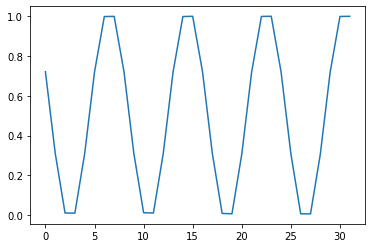

In [49]:
# Due to sigmoid function, the output cannot be negative.  I could however, use linear layer to fix this?
maxVal = data.max()
minVal = data.min()
dataScaled = (data - minVal) / (maxVal - minVal)
plt.plot(dataScaled[-1, :])

In [50]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length, num_channels, frame_size):
        X_, y_ = self.split_sequence(data, seq_length)
        X_ = X_.reshape(X_.shape[0], num_channels, seq_length, *frame_size)
        self.X = torch.from_numpy(
            X_
        ).float()  # numpy array data is double but the parameters in the nn layers are float.
        self.y = torch.from_numpy(y_).float()

    def __len__(self):
        "Denotes the total number of samples"
        return self.X.shape[0]

    # Probabably a better way here: https://diegslva.github.io/2017-05-02-first-post/
    def split_sequence(self, data, nSeq):
        X, y = list(), list()
        nRow = data.shape[0]
        for i in range(nRow):
            # find the end of this pattern
            end_ix = i + nSeq
            # check if we are beyond the sequence
            if end_ix > nRow - 1:
                break
                # gather input and output parts of the pattern
            seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        X = self.X[index]
        y = self.y[index]
        X = X.transpose(0,1) #Change to seq_len, channel, H, W)
        return X, y 

In [51]:
ds = MyDataset(dataScaled, seq_length, num_channels, frame_size)
train_loader = DataLoader(ds, shuffle=True, batch_size=batch_size)

torch.Size([10, 10, 1, 1, 32])
torch.Size([10, 32])


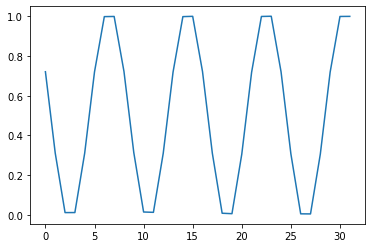

In [52]:
train_, phi_ = next(iter(train_loader))
print(train_.shape)
print(phi_.shape)
train = train_[0, 0, -1, 0, :].cpu().detach().numpy()
plt.plot(train)
plt.show()


In [53]:
convlstm_encoder_params = [
    [
        OrderedDict(
            {"conv1_leaky_1": [1, 16, (1, 3), (1, 1), (0, 1)]}
        ),  # in_channel, out_channel, kernel_size, stride, padding
        OrderedDict({"conv2_leaky_1": [64, 64, (1, 3), (1, 2), (0, 1)]}),
        OrderedDict({"conv3_leaky_1": [96, 96, (1, 3), (1, 2), (0, 1)]}),
    ],
    [
        CLSTM_cell(
            shape=(1, 32), input_channels=16, filter_size=(1, 5), num_features=64
        ),
        CLSTM_cell(
            shape=(1, 16), input_channels=64, filter_size=(1, 5), num_features=96
        ),
        CLSTM_cell(
            shape=(1, 8), input_channels=96, filter_size=(1, 5), num_features=96
        ),
    ],
]

convlstm_decoder_params = [
    [
        OrderedDict({"deconv1_leaky_1": [96, 96, (1, 4), (1, 2), (0, 1)]}),
        OrderedDict({"deconv2_leaky_1": [96, 96, (1, 4), (1, 2), (0, 1)]}),
        OrderedDict(
            {
                "conv3_leaky_1": [64, 16, (1, 3), (1, 1), (0, 1)],
                "conv4_leaky_1": [16, 1, 1, 1, 0],
            }  # in_channel, out_channels, kernel_size, stride, padding
        ),
    ],
    [
        CLSTM_cell(
            shape=(1, 8), input_channels=96, filter_size=(1, 5), num_features=96
        ),
        CLSTM_cell(shape=(1, 16), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(1, 32), input_channels=96, filter_size=5, num_features=64),
    ],
]


In [54]:
def calConvSize(Win, kernel_size, stride, padding):
    # The size is the floor value.
    # https://discuss.pytorch.org/t/how-to-calculate-the-output-size-after-conv2d-in-pytorch/20405
    Wout = ((Win - kernel_size + 2 * padding) / stride) + 1
    print(f"{Win} => {Wout} (= {np.floor(Wout)}) ")


def calTransConvSize(Win, kernel_size, stride, padding, dilation=1, output_padding=0):
    Wout = (
        (Win - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )
    print(f"{Win} => {Wout}")


calConvSize(Win=32, kernel_size=3, stride=1, padding=1)
calConvSize(Win=16, kernel_size=3, stride=2, padding=1)
calConvSize(Win=1, kernel_size=1, stride=1, padding=0)

calTransConvSize(Win=16, kernel_size=4, stride=2, padding=1)
calTransConvSize(Win=1, kernel_size=1, stride=1, padding=0)


32 => 32.0 (= 32.0) 
16 => 8.5 (= 8.0) 
1 => 1.0 (= 1.0) 
16 => 32
1 => 1


In [55]:
encoder = Encoder(convlstm_encoder_params[0], convlstm_encoder_params[1])
decoder = Decoder(convlstm_decoder_params[0], convlstm_decoder_params[1])

In [56]:
class ED(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        state = self.encoder(input)
        output = self.decoder(state)
        return output

model = ED(encoder, decoder)

optim = Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss(reduction="sum")

In [57]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [58]:
class History:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.epoch = []
        self.counter = 1
    def __call__(self, train_loss, val_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.epoch.append(self.counter)
        self.counter += 1


In [59]:
num_epochs = 1000
patience = 20
history = History()


In [60]:
# num_epochs = 100
# (input, target) = next(iter(train_loader))

# for epoch in range(1, num_epochs + 1):

#     train_loss = 0
#     model.train() #https://stackoverflow.com/a/51433411
#     outputs = model(input)
#     output = outputs[:, -1, ...]
#     loss = criterion(output.flatten(), target.flatten())
#     loss.backward()
#     torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
#     optim.step()
#     optim.zero_grad()
#     train_loss += loss.item()
#     train_loss /= batch_size

#     val_loss = 0
#     model.eval()
#     with torch.no_grad():
#         outputs = model(input)
#         output = outputs[:, -1, ...]
#         loss = criterion(output.flatten(), target.flatten())
#         val_loss += loss.item()
#     val_loss /= batch_size

#     print(
#         "Epoch:{} Training Loss:{:.8f} Validation Loss:{:.8f}\n".format(
#             epoch, train_loss, val_loss
#         )
#     )


# phiPred = output[-1,0,0,:].cpu().detach().numpy()
# phi = target[-1,:].cpu().detach().numpy()
# plt.plot(phi, '--*')
# plt.plot(phiPred)

In [61]:
# run_mode = 'train'
run_mode = 'eval'

In [62]:
if run_mode == 'train':
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(1, num_epochs + 1):

        train_loss = 0
        model.train()  # https://stackoverflow.com/a/51433411
        for batch_num, (input, target) in enumerate(train_loader, 1):
            outputs = model(input)
            output = outputs[:, -1, ...]
            loss = criterion(output.flatten(), target.flatten())
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
            optim.step()
            optim.zero_grad()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)

        val_loss = 0
        model.train()
        with torch.no_grad():
            for input, target in train_loader:
                outputs = model(input)
                output = outputs[:, -1, ...]
                loss = criterion(output.flatten(), target.flatten())
                val_loss += loss.item()
        val_loss /= len(train_loader.dataset)

        history(train_loss, val_loss)
        print(
            "Epoch:{} Training Loss:{:.8f} Validation Loss:{:.8f}\n".format(
                epoch, train_loss, val_loss
            )
        )

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


In [63]:
if run_mode == 'eval':
    model.load_state_dict(torch.load('checkpoint-en-de.pt'))

torch.Size([10, 1, 1, 32])
torch.Size([10, 32])


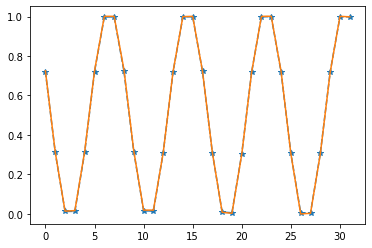

In [68]:
train_, phi_ = next(iter(train_loader))
model.eval()
preds_ = model(train_)
pred_ = preds_[:, -1, ...]
print(pred_.size())
print(phi_.size())

pred = pred_[-1, 0, 0, :].cpu().detach().numpy()
phi = phi_[-1, :].cpu().detach().numpy()
plt.plot(phi, "--*")
plt.plot(pred)